<a href="https://colab.research.google.com/github/teethavattcp/teethavat_port_data/blob/main/04_RFM_cust_segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFM Segmentation for each household

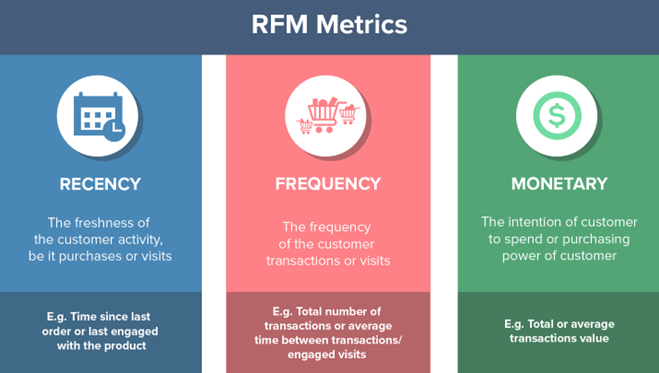

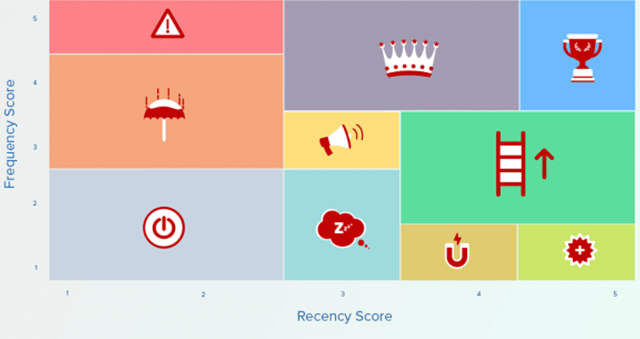

# 1) Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import plotly.express as px

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=42995ac95526822f49bb042671cafccf08bed454c903919f9cede5d673d2c4b8
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
import pandasql

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

In [ ]:
import datetime as dt
from datetime import datetime

In [ ]:
from pathlib import Path

#Define fn for cleaning raw data

##count_total_duplicates(df)

In [ ]:
def count_total_duplicates(df):
    # Identifying duplicate rows (excluding the first occurrence)
    duplicates = df.duplicated(keep='first')

    # Summing the number of duplicate rows
    total_duplicates = duplicates.sum()

    return total_duplicates

In [ ]:
# Example usage
data = {
    'A': ['foo', 'bar', 'foo', 'baz', 'foo'],
    'B': ['one', 'one', 'two', 'two', 'one'],
    'C': [1, 2, 3, 4, 1],
    'D': [5, 6, 7, 8, 5]
}
df_test = pd.DataFrame(data)
df_test

,A,B,C,D
0,foo,one,1,5
1,bar,one,2,6
2,foo,two,3,7
3,baz,two,4,8
4,foo,one,1,5


In [ ]:
total_duplicates = count_total_duplicates(df_test)
print(f'Total number of duplicate rows: {total_duplicates}')

Total number of duplicate rows: 1


##check_duplication_in_df(df)

In [ ]:
def check_duplication_in_df(df):
  total_duplicates = count_total_duplicates(df)
  if total_duplicates > 0:
    print(f"There are {total_duplicates} duplicate rows in the DataFrame.")
    df.drop_duplicates(inplace=True)
    print("Duplicate rows were dropped.")
    print("New shape of dataframe after dropping duplicate rows:",df.shape)
  elif total_duplicates == 0:
    print("No duplicate rows found.")

## format_number(x)

In [ ]:
def format_number(x):
    if isinstance(x, float):
        if x.is_integer():
            return '{:.0f}'.format(x)  # Convert to integer if it's a whole number
        else:
            return '{:.2f}'.format(x)  # Keep as float with 2 decimal places
    return x

## explore_df(df_for_eda)

In [ ]:
def explore_df(df_for_eda):
  print("#Check shape")
  print(df_for_eda.shape,"\n")

  print("#Check duplication")
  check_duplication_in_df(df_for_eda)

  print("\n#Check missing value")
  if df_for_eda.isnull().sum().sum() == 0:
    print("No missing values found.")
  else:
    print("Missing values found:", df_for_eda.isnull().sum().sum())
    print("\nNumber of missing values:\n",df_for_eda.isnull().sum())
    print("\nPercentage of missing values:\n",df_for_eda.isnull().sum()/len(df_for_eda)*100)

  print("\n#Check data type")
  print(df_for_eda.info(),"\n")

  print("\n#Check unique value")
  print(df_for_eda.nunique(),"\n")

  print("#List of column name:\n",df_for_eda.columns.tolist())

## explore_classes_in_df(df,df_col_cat)

In [ ]:
def explore_classes_in_df(df,df_col_cat):
  for col in df_col_cat:
    print ("\n-------- %s --------" % col)
    print (df[col].value_counts())

In [ ]:
def explore_distribution_in_df(df,df_col_num):
  for col in df_col_num:
    #histogram plot
    #plt.figure(figsize=(2.5, 1.25))
    print ("\n-------- %s --------" % col)

    # Create the histogram plot to calculate the max count
    hist = sns.histplot(df[col])

    # Calculate the maximum count (frequency)
    max_count = hist.patches[0].get_height()  # Initialize with the first bar's height
    for bar in hist.patches:
        if bar.get_height() > max_count:
            max_count = bar.get_height()

    # Clear the current plot to redraw with y-axis limit
    plt.clf()

    # Create the histogram plot again
    sns.histplot(df[col])

    # Set the maximum limit for the y-axis
    plt.ylim(top=1.3 * max_count)

    # Display the plot
    plt.title(f'Histogram of {col}')
    plt.show()

    #box plot
    #plt.figure(figsize=(2.5, 1.25))
    plt.clf()
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    plt.show()

## deepexploredf(df,df_col_cat, df_col_num)

In [ ]:
import matplotlib.cm as cm

In [ ]:
def deepexploredf(df,df_col_cat, df_col_num):
  print("##Explore categorical data")
  if len(df_col_cat) == 0:
    print("No categorical column found.")
  else:
    explore_classes_in_df(df,df_col_cat)

  print("\n##Explore numerical data")
  if len(df_col_num) == 0:
    print("No numerical data found.")
  else:
    print("#Check statistical summary")
    print(df[df_col_num].describe().applymap(format_number).transpose().to_markdown())
    print("#Check correlation")
    #plt.figure(figsize = (2,1.25))
    #plt.rcParams.update({'font.size': 10})
    sns.heatmap(df[df_col_num].corr(), annot =True, cmap=cm.coolwarm_r, vmin=-1, vmax=1)
    plt.show()
    #sns.pairplot(df[df_col_num])
    #plt.show()

## export_to_csv(path_of_folder,file_name,df)

In [ ]:
def export_to_csv(path_of_folder,file_name,df):
  filepath = Path(str(path_of_folder)+str(file_name)+'.csv')
  filepath.parent.mkdir(parents=True, exist_ok=True)
  df.to_csv(filepath,mode = 'w', index=False)
  print(str(file_name)+'.csv has been exported successfully.')

In [ ]:
path_folder='/content/drive/MyDrive/DATA_SCI_SKILL/202406_CompleteJourneyProj/data set'+'/'

## explore_ranges_of_num_field(df,df_col_num)

In [ ]:
def explore_ranges_of_num_field(df,list_col_num):
  for col in df[list_col_num]:
    count_less_than_0_butsmallamount = len(df[(df[col] < 0) & (df[col] > -0.01)]) #-0.01 < value < 0
    count_less_than_0_butlargeamount = len(df[df[col] <= -0.01]) #-0.01 =< value
    count_equal_to_0 = len(df[df[col] == 0])
    count_greater_than_0_but_smallamount = len(df[(df[col] > 0)& (df[col] < 0.01)])
    count_greater_than_0_but_largeamount = len(df[(df[col] >= 0.01)])
    print(col,':')
    print(f'Count of values << 0: {count_less_than_0_butlargeamount}')
    print(f'Count of -0.01 < values < 0: {count_less_than_0_butsmallamount}')
    print(f'Count of values = 0: {count_equal_to_0}')
    print(f'Count of 0 < values < 0.01: {count_greater_than_0_but_smallamount}')
    print(f'Count of values >> 0: {count_greater_than_0_but_largeamount}')
    print('\n')

## add_status_column(df, left_col, right_col, status_col='status')

Add a status column to the DataFrame based on the comparison of two columns from left and right DataFrames.
```
 Parameters:
    - df (pd.DataFrame): The DataFrame resulting from an outer join.
    - left_col (str): The column name from the left DataFrame.
    - right_col (str): The column name from the right DataFrame.
    - status_col (str): The name of the new status column. Default is 'status'.

 Returns:
    - pd.DataFrame: The DataFrame with the added status column.

```


In [ ]:
def add_status_column(df, left_col, right_col, status_col='status'):
    conditions = [
        (df[left_col].notna()) & (df[right_col].notna()),  # Found value in both tables
        (df[left_col].notna()) & (df[right_col].isna()),   # Found value only in the left table
        (df[left_col].isna()) & (df[right_col].notna())    # Found value only in the right table
    ]

    choices = ['Found in both', 'Found only in left', 'Found only in right']

    df[status_col] = pd.Series(np.select(conditions, choices, default=None))
    return df

## dict_k2v_v2k(input_dict):

In [ ]:
def dict_k2v_v2k(input_dict):
  output_dict = {}

  for data_type, columns in input_dict.items():
    for column in columns:
        output_dict[column] = data_type

  return output_dict

## replace_valueindf(df,col_key_name,col_val_name,dict_kv_replace)

In [ ]:
def replace_valueindf(df,col_key_name,col_val_name,dict_kv_replace):
  if df[col_key_name] in dict_kv_replace.keys():
    df[col_val_name] = dict_kv_replace[df[col_key_name]]
  return df

# Prepare data for clustering

In [ ]:
df_trans = pd.read_csv('/content/drive/MyDrive/DATA_SCI_SKILL/202406_CompleteJourneyProj/data set/fact_trans_x_couponredempt.csv')
df_trans = df_trans.rename(columns={'PRODUCT_ID_x': 'PRODUCT_ID'})
df_trans

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,TOTAL_DISC,If_used_retail_loyalprog,If_used_manu_coupon,If_used_giveaway_promo,Actual_card_price,Cust_paid_price,COUPON_UPC
0,1,27601281299,51,825123,1,3.99,436,0.00,1456,8,0.0,0.0,0.00,0,0,0,3.99,3.99,NaN
1,1,27601281299,51,831447,1,2.99,436,0.00,1456,8,0.0,0.0,0.00,0,0,0,2.99,2.99,NaN
2,1,27601281299,51,840361,1,1.09,436,-0.30,1456,8,0.0,0.0,-0.30,1,0,0,1.39,1.09,NaN
3,1,27601281299,51,845307,1,3.71,436,-0.62,1456,8,0.0,0.0,-0.62,1,0,0,4.33,3.71,NaN
4,1,27601281299,51,852014,1,2.79,436,-1.20,1456,8,0.0,0.0,-1.20,1,0,0,3.99,2.79,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2581261,2500,42250641157,708,1109947,1,3.19,447,-0.80,1620,102,0.0,0.0,-0.80,1,0,0,3.99,3.19,NaN
2581262,2500,42250641157,708,1117514,1,1.99,447,0.00,1620,102,0.0,0.0,0.00,0,0,0,1.99,1.99,NaN
2581263,2500,42250641157,708,8019186,1,2.59,447,-1.00,1620,102,0.0,0.0,-1.00,1,0,0,3.59,2.59,NaN
2581264,2500,42250641157,708,15596705,1,2.77,447,-3.02,1620,102,-1.0,0.0,-3.02,1,0,0,5.79,3.77,NaN


In [ ]:
df_trans['DAY'].describe()

,DAY
count,2.581266e+06
mean,3.886560e+02
std,1.897255e+02
min,1.000000e+00
25%,2.290000e+02
50%,3.900000e+02
75%,5.530000e+02
max,7.110000e+02


## Prepare necessary data fields

Key:
-	Cust_id

Input:
1. Recency:

- Month-to-date Recency: shows the time elapsed since the last purchase. Use this field to capture how recent the customer's last purchase was.

2. Frequency:

- Total Usage Frequency: measures how often a customer makes a purchase by counting distinct BASKET_ID per household. This is suitable for the frequency component of RFM.
- Mean-time-between-purchase: provide additional insights into purchase intervals.

3. Monetary:

- Total Revenue: This represents the total amount spent by the customer, which fits perfectly as the monetary component of RFM.
- Total Quantity: This can also be used to understand purchasing behavior but is secondary to Total Revenue for the monetary aspect.

Output:
-	Customer behavior


In [ ]:
df_trans.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'TOTAL_DISC',
       'If_used_retail_loyalprog', 'If_used_manu_coupon',
       'If_used_giveaway_promo', 'Actual_card_price', 'Cust_paid_price',
       'COUPON_UPC'],
      dtype='object')

## Feature Engineering

In [ ]:
df_RFM = pandasql.sqldf('''
    SELECT household_key,
          711-MAX(DAY) AS Month_to_date_Recency,
          COUNT(DISTINCT BASKET_ID) AS Total_Basket_Frequency,
          SUM(Cust_paid_price) AS Total_Revenue,
          SUM(QUANTITY) AS Total_Quantity,
          COUNT(DISTINCT PRODUCT_ID) AS Total_productid_purchase
    FROM df_trans
    GROUP BY household_key
''')
df_RFM

,household_key,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Total_productid_purchase
0,1,5,85,4006.341667,1997,674
1,2,43,45,1805.348333,834,545
2,3,8,47,1856.830421,8540,515
3,4,84,30,1019.081333,382,164
4,5,8,40,741.465000,245,199
...,...,...,...,...,...,...
2495,2496,28,63,3347.263131,130304,755
2496,2497,11,221,5543.457956,61236,987
2497,2498,1,172,2360.113624,31339,642
2498,2499,2,90,2692.612989,143449,705


In [ ]:
df_RFM_MTBP = pandasql.sqldf('''
    WITH PurchaseDates AS (
    SELECT
        household_key,
        BASKET_ID,
        DAY AS Purchase_date,
        LAG(DAY) OVER (PARTITION BY household_key ORDER BY DAY) AS Previous_Purchase_date
    FROM
        df_trans
    ),
    DateDifferences AS (
    SELECT
        household_key,
        Purchase_date - Previous_Purchase_date AS Days_Between
    FROM
        PurchaseDates
    WHERE
        Previous_Purchase_date IS NOT NULL
    )
SELECT
    household_key,
    AVG(Days_Between) AS Mean_time_between_purchase
FROM
    DateDifferences
GROUP BY
    household_key;
''')
df_RFM_MTBP

,household_key,Mean_time_between_purchase
0,1,0.383265
1,2,0.793539
2,3,0.641304
3,4,1.749164
4,5,2.796380
...,...,...
2495,2496,0.382950
2496,2497,0.317833
2497,2498,0.705128
2498,2499,0.550388


In [ ]:
df_RFM_MTBP['Mean_time_between_purchase'].describe()

,Mean_time_between_purchase
count,2500.000000
mean,1.956828
std,3.647899
min,0.000000
25%,0.438324
50%,0.855762
75%,1.892844
max,56.000000


####df_RFM

In [ ]:
df_RFM['Mean_time_between_purchase'] = df_RFM_MTBP['Mean_time_between_purchase']
df_RFM

,household_key,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Total_productid_purchase,Mean_time_between_purchase
0,1,5,85,4006.341667,1997,674,0.383265
1,2,43,45,1805.348333,834,545,0.793539
2,3,8,47,1856.830421,8540,515,0.641304
3,4,84,30,1019.081333,382,164,1.749164
4,5,8,40,741.465000,245,199,2.796380
...,...,...,...,...,...,...,...
2495,2496,28,63,3347.263131,130304,755,0.382950
2496,2497,11,221,5543.457956,61236,987,0.317833
2497,2498,1,172,2360.113624,31339,642,0.705128
2498,2499,2,90,2692.612989,143449,705,0.550388


## Data Selection

If there is strong dependence or correlation between variables, it can impact the clustering results. Highly correlated variables may dominate the clustering process and lead to biased clusters.

In [ ]:
df_RFM_key = df_RFM['household_key']
df_RFM_key

,household_key
0,1
1,2
2,3
3,4
4,5
...,...
2495,2496
2496,2497
2497,2498
2498,2499


In [ ]:
df_RFM_val = df_RFM.copy()
df_RFM_val.drop('household_key',axis = 1, inplace = True)
df_RFM_val

,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Total_productid_purchase,Mean_time_between_purchase
0,5,85,4006.341667,1997,674,0.383265
1,43,45,1805.348333,834,545,0.793539
2,8,47,1856.830421,8540,515,0.641304
3,84,30,1019.081333,382,164,1.749164
4,8,40,741.465000,245,199,2.796380
...,...,...,...,...,...,...
2495,28,63,3347.263131,130304,755,0.382950
2496,11,221,5543.457956,61236,987,0.317833
2497,1,172,2360.113624,31339,642,0.705128
2498,2,90,2692.612989,143449,705,0.550388


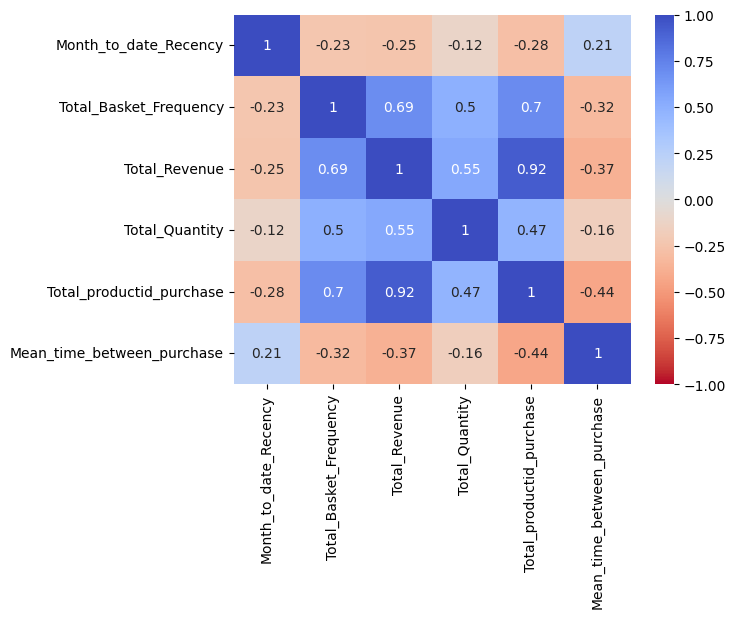

In [ ]:
#plt.figure(figsize = (2,1.25))
#plt.rcParams.update({'font.size': 10})
sns.heatmap(df_RFM_val[df_RFM_val.columns].corr(), annot =True, cmap=cm.coolwarm_r, vmin=-1, vmax=1)
plt.show()

In [ ]:
df_RFM_val.drop('Total_productid_purchase',axis = 1, inplace = True)
df_RFM_val

,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Mean_time_between_purchase
0,5,85,4006.341667,1997,0.383265
1,43,45,1805.348333,834,0.793539
2,8,47,1856.830421,8540,0.641304
3,84,30,1019.081333,382,1.749164
4,8,40,741.465000,245,2.796380
...,...,...,...,...,...
2495,28,63,3347.263131,130304,0.382950
2496,11,221,5543.457956,61236,0.317833
2497,1,172,2360.113624,31339,0.705128
2498,2,90,2692.612989,143449,0.550388


Drop a correlate field

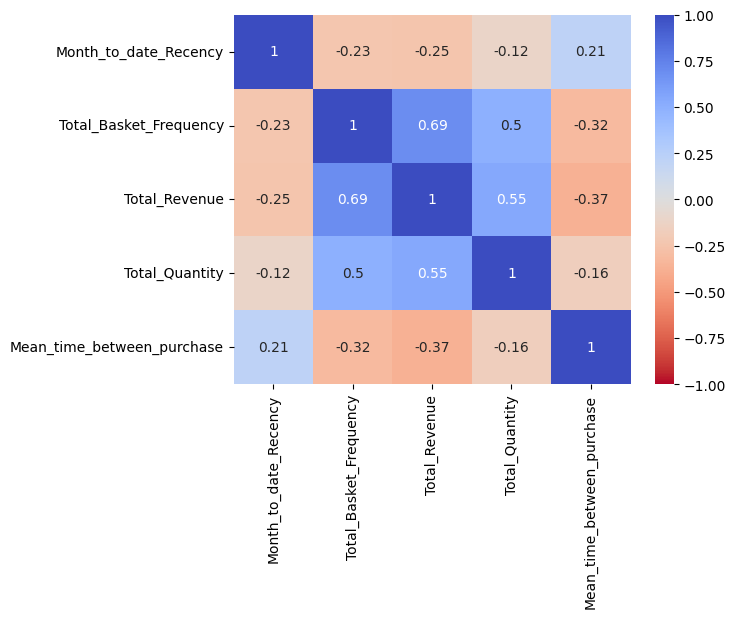

In [ ]:
sns.heatmap(df_RFM_val[df_RFM_val.columns].corr(), annot =True, cmap=cm.coolwarm_r, vmin=-1, vmax=1)
plt.show()

## Z-normalization

In [ ]:
X = df_RFM_val[df_RFM_val.columns[:]].to_numpy(dtype=np.float32)
X

array([[5.0000000e+00, 8.5000000e+01, 4.0063416e+03, 1.9970000e+03,
        3.8326508e-01],
       [4.3000000e+01, 4.5000000e+01, 1.8053484e+03, 8.3400000e+02,
        7.9353935e-01],
       [8.0000000e+00, 4.7000000e+01, 1.8568304e+03, 8.5400000e+03,
        6.4130437e-01],
       ...,
       [1.0000000e+00, 1.7200000e+02, 2.3601135e+03, 3.1339000e+04,
        7.0512819e-01],
       [2.0000000e+00, 9.0000000e+01, 2.6926130e+03, 1.4344900e+05,
        5.5038762e-01],
       [3.0000000e+00, 1.1300000e+02, 3.9747529e+03, 2.4736500e+05,
        4.2243117e-01]], dtype=float32)

In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
Z = scaler.fit_transform(X)
Z

array([[-0.32775232, -0.21970016,  0.58240885, -0.41847074, -0.43144765],
       [ 0.27754453, -0.5662905 , -0.28389293, -0.4232292 , -0.31895652],
       [-0.27996573, -0.548961  , -0.26362982, -0.39169982, -0.36069712],
       ...,
       [-0.39146778,  0.53413385, -0.06553968, -0.29841697, -0.34319755],
       [-0.37553892, -0.17637637,  0.06533075,  0.16028477, -0.38562515],
       [-0.35961005,  0.02291309,  0.5699757 ,  0.5854605 , -0.4207089 ]],
      dtype=float32)

# Generate k-mean clustering model

## Finding the optimal "K"

### Elbow method
The elbow method examines the distortion or inertia as a function of the number of clusters (k). It looks for the "elbow" or bend in the plot and suggests selecting the number of clusters where adding more clusters does not significantly reduce the distortion. This method focuses on minimizing within-cluster variance. If the elbow method suggests a clear bend in the plot, it can be a reasonable choice for determining the number of clusters.

In [ ]:
# Run K-means for a set of k
from tqdm import tqdm
distortions = []
models = []
K = list(range(1, 10+1))
for k in tqdm(K):
    model = KMeans(n_clusters=k)
    model.fit(Z)
    models.append(model)
    distortions.append(model.inertia_) #keep inertia value

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 10%|█         | 1/10 [00:00<00:01,  6.85it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 30%|███       | 3/10 [00:00<00:00, 11.21it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluste

In [ ]:
fig = px.line(x=K, y=distortions, title='The Elbow Method showing the optimal k',markers=True)
fig.update_layout(xaxis_title='k', yaxis_title='Distortion')
fig.show()

#### Check ratio for "Knee finding"

In [ ]:
for i in range(len(distortions)-1):
  print(str(i+1) + "-->" + str(i+2) + ": Diff = " + str(distortions[i+1] - distortions[i]))

1-->2: Diff = -3537.453125
2-->3: Diff = -1991.9404296875
3-->4: Diff = -1096.17236328125
4-->5: Diff = -1080.5927734375
5-->6: Diff = -528.35400390625
6-->7: Diff = -460.1552734375
7-->8: Diff = -371.156005859375
8-->9: Diff = -354.5107421875
9-->10: Diff = -310.726318359375


In [ ]:
for i in range(1,len(distortions)-1):
  print('k = ' +str(i+1) + ": Ratio = " + str((distortions[i] - distortions[i-1])/(distortions[i+1] - distortions[i])))

k = 2: Ratio = 1.775882989409961
k = 3: Ratio = 1.8171781157890938
k = 4: Ratio = 1.0144176328277574
k = 5: Ratio = 2.0452059896365204
k = 6: Ratio = 1.1482080819356577
k = 7: Ratio = 1.2397893774399689
k = 8: Ratio = 1.0469527765764326
k = 9: Ratio = 1.1409099301897097


In the elbow method, it can be grouped into six clusters as the bending point where the slope had changed significantly occurred between the number of clusters at five (k=5).

## Clustering

In [ ]:
model = KMeans(n_clusters=5, random_state= 2024)
model.fit(Z)
y_pred = model.fit_predict(Z)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
cluster_pred = list(y_pred)

In [ ]:
cluster = {0:[],1:[] ,2:[],3:[],4:[]} #{(cluster)th : memberindex_in_cluster}
for i in range(len(cluster_pred)):
  cluster[cluster_pred[i]].append(i+1)

## Result

In [ ]:
df_cluster_count_member = pd.DataFrame([(key, member) for key, members in cluster.items() for member in members], columns=['cluster', 'member'])
df_cluster_count_member = df_cluster_count_member.groupby('cluster').size().reset_index(name='count')
df_cluster_count_member

,cluster,count
0,0,1620
1,1,100
2,2,622
3,3,60
4,4,98


# Visualize clusters

## Prepare data for plotting

In [ ]:
df_Z = pd.DataFrame(Z, index = list(range(1,Z.shape[0]+1)),columns = list(df_RFM_val.columns))
df_Z

,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Mean_time_between_purchase
1,-0.327752,-0.219700,0.582409,-0.418471,-0.431448
2,0.277545,-0.566290,-0.283893,-0.423229,-0.318957
3,-0.279966,-0.548961,-0.263630,-0.391700,-0.360697
4,0.930628,-0.696262,-0.593364,-0.425079,-0.056938
5,-0.279966,-0.609614,-0.702633,-0.425639,0.230193
...,...,...,...,...,...
2496,0.038612,-0.410325,0.322998,0.106502,-0.431534
2497,-0.232179,0.958707,1.187412,-0.176092,-0.449388
2498,-0.391468,0.534134,-0.065540,-0.298417,-0.343198
2499,-0.375539,-0.176376,0.065331,0.160285,-0.385625


In [ ]:
df_Z_0 = df_Z.loc[cluster[0]]
df_Z_0

,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Mean_time_between_purchase
1,-0.327752,-0.219700,0.582409,-0.418471,-0.431448
2,0.277545,-0.566290,-0.283893,-0.423229,-0.318957
3,-0.279966,-0.548961,-0.263630,-0.391700,-0.360697
4,0.930628,-0.696262,-0.593364,-0.425079,-0.056938
5,-0.279966,-0.609614,-0.702633,-0.425639,0.230193
...,...,...,...,...,...
2493,2.268653,0.005584,-0.203612,-0.074712,-0.363935
2494,-0.264037,-0.652938,-0.340094,-0.189844,-0.272669
2496,0.038612,-0.410325,0.322998,0.106502,-0.431534
2498,-0.391468,0.534134,-0.065540,-0.298417,-0.343198


In [ ]:
df_Z_1 = df_Z.loc[cluster[1]]
df_Z_1

,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Mean_time_between_purchase
13,-0.375539,1.426604,1.721190,7.199276,-0.463800
19,-0.407397,2.691659,2.531330,1.739052,-0.498768
40,-0.391468,2.509699,2.577424,4.648553,-0.490018
58,-0.407397,1.365951,1.761196,4.520132,-0.477397
113,-0.375539,0.967372,3.586118,3.971016,-0.498343
...,...,...,...,...,...
2351,-0.359610,1.833848,3.931502,3.980070,-0.502650
2360,-0.359610,2.007143,1.465571,3.553274,-0.472135
2400,-0.407397,2.423051,2.538448,3.346709,-0.492813
2427,-0.391468,2.033137,1.479654,2.274081,-0.469717


In [ ]:
df_Z_2 = df_Z.loc[cluster[2]]
df_Z_2

,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Mean_time_between_purchase
6,-0.343681,1.201320,0.941916,-0.039214,-0.445857
8,-0.327752,0.022913,0.866814,-0.147055,-0.447137
17,-0.056962,0.118225,0.122504,0.784252,-0.359166
18,-0.407397,0.438822,1.167657,0.640938,-0.445629
20,-0.407397,2.397057,1.141047,1.525781,-0.451817
...,...,...,...,...,...
2484,-0.343681,0.404162,1.452178,0.986468,-0.461962
2488,-0.295895,0.074902,1.112181,0.695719,-0.448166
2489,-0.264037,0.248197,2.115813,0.460579,-0.482833
2497,-0.232179,0.958707,1.187412,-0.176092,-0.449388


In [ ]:
df_Z_3 = df_Z.loc[cluster[3]]
df_Z_3

,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Mean_time_between_purchase
12,2.889878,-0.895551,-0.898507,-0.426220,0.824938
102,8.066759,-0.886887,-0.892892,-0.426073,-0.194455
130,5.534070,-0.782909,-0.831451,-0.293159,0.033772
173,4.642054,-0.869557,-0.924470,-0.426146,0.573917
179,2.603159,-0.626944,-0.814186,-0.425463,0.111410
231,3.702250,-0.878222,-0.904670,-0.347417,0.603217
272,3.638535,-0.895551,-0.873413,-0.381700,0.266893
298,6.266798,-0.895551,-0.907967,-0.426138,0.052457
313,9.548144,-0.921546,-0.960901,-0.426461,-0.277169
355,5.008418,-0.895551,-0.897736,-0.426224,0.668220


In [ ]:
df_Z_4 = df_Z.loc[cluster[4]]
df_Z_4

,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Mean_time_between_purchase
11,4.355334,-0.912881,-0.982310,-0.426560,4.334286
54,3.033238,-0.860892,-0.957849,-0.426470,3.293751
61,-0.152535,-0.860892,-0.947491,-0.426380,3.801217
70,-0.311823,-0.678932,-0.965712,-0.426433,3.617969
89,0.755410,-0.860892,-0.925886,-0.426429,2.610636
...,...,...,...,...,...
2403,1.328850,-0.869557,-0.950108,-0.426408,2.047135
2417,-0.327752,-0.878222,-0.927617,-0.426298,2.479504
2428,-0.264037,-0.791574,-0.964288,-0.023053,4.584279
2444,-0.375539,-0.904216,-0.969336,-0.426551,9.261980


In [ ]:
df_cluster = pd.DataFrame({
    'Behavior_0': list(df_Z_0.mean(axis = 0)),
    'Behavior_1': list(df_Z_1.mean(axis = 0)),
    'Behavior_2': list(df_Z_2.mean(axis = 0)),
    'Behavior_3': list(df_Z_3.mean(axis = 0)),
    'Behavior_4': list(df_Z_4.mean(axis = 0))
    }, index = list(df_RFM_val.columns))
df_cluster

,Behavior_0,Behavior_1,Behavior_2,Behavior_3,Behavior_4
Month_to_date_Recency,-0.078741,-0.363911,-0.315947,5.072398,0.572716
Total_Basket_Frequency,-0.385288,2.658040,0.783420,-0.775978,-0.840468
Total_Revenue,-0.434433,2.478674,0.961871,-0.828062,-0.945783
Total_Quantity,-0.309108,3.473985,0.339458,-0.343565,-0.379305
Mean_time_between_purchase,-0.047904,-0.469973,-0.435217,0.469766,3.746129


## Plot graph

In [ ]:
print('Each Average Z-Score for each numerical variable by each cluster')
px.line(df_cluster
        ,markers=True)

Each Average Z-Score for each numerical variable by each cluster


## Interpret result

**Behavior_0: “Regular Minimal Spenders”**

This cluster shows below-average engagement across all metrics.

-	Month-to-date Recency: Near average (slightly below average).
-	Total_Basket_Frequency: Low frequency (below average).
-	Total_Revenue: Low revenue (below average).
-	Total_Quantity: Low quantity (below average).
-	Mean_time_between_purchase: Near average (slightly below average).

**Behavior_1: “Shining Star Customers”**

This cluster has very recent purchases and outstanding engagement across all metrics.

-	Month-to-date Recency: Very recent (very high).
-	Total_Basket_Frequency: High frequency (significantly above average).
-	Total_Revenue: High revenue (significantly above average).
-	Total_Quantity: High quantity (significantly above average).
-	Mean_time_between_purchase: Recent purchases (slightly below average).

**Behavior_2: “Balanced Buyers”**

This cluster exhibits moderate levels of engagement and spending.

-	Month-to-date Recency: Slightly recent (below average).
-	Total_Basket_Frequency: Moderate frequency (slightly above average).
-	Total_Revenue: Moderate revenue (slightly above average).
-	Total_Quantity: Moderate quantity (slightly above average).
-	Mean_time_between_purchase: Slightly recent purchases (below average).


**Behavior_3: “Quiet Low Spenders”**

This cluster has low recent engagement and spending, indicating potential dormant customers.

-	Month-to-date Recency: Very low recency (very high, indicating a long time since last purchase).
-	Total_Basket_Frequency: Low frequency (below average).
-	Total_Revenue: Low revenue (below average).
-	Total_Quantity: Low quantity (below average).
-	Mean_time_between_purchase: Recent purchases (average).


**Behavior_4: “Sleeping Star Customers”**

This cluster has recent activity but low engagement and spending, suggesting they might be high-value prospects if improved engagement is achieved.

-	Month-to-date Recency: Slightly recent (above average).
-	Total_Basket_Frequency: Low frequency (below average).
-	Total_Revenue: Low revenue (below average).
-	Total_Quantity: Low quantity (below average).
-	Mean_time_between_purchase: Very long time between purchases (very high).


# Export clustering result

## Prepare exported data

In [ ]:
cluster_kv = [[0,'Regular Minimal Spenders'],
              [1,'Shining Star Customers'],
              [2,'Balanced Buyers'],
              [3,'Quiet Low Spenders'],
              [4,'Sleeping Star Customers']]
df_cust_behavior_kv = pd.DataFrame(data=cluster_kv,columns=['cluster','Cust_behavior'])
df_cust_behavior_kv

,cluster,Cust_behavior
0,0,Regular Minimal Spenders
1,1,Shining Star Customers
2,2,Balanced Buyers
3,3,Quiet Low Spenders
4,4,Sleeping Star Customers


In [ ]:
df_result = df_RFM.copy()
df_result['cluster'] = cluster_pred
df_result=df_result.merge(df_cust_behavior_kv, on = 'cluster', how = 'left')
df_result

,household_key,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Total_productid_purchase,Mean_time_between_purchase,cluster,Cust_behavior
0,1,5,85,4006.341667,1997,674,0.383265,0,Regular Minimal Spenders
1,2,43,45,1805.348333,834,545,0.793539,0,Regular Minimal Spenders
2,3,8,47,1856.830421,8540,515,0.641304,0,Regular Minimal Spenders
3,4,84,30,1019.081333,382,164,1.749164,0,Regular Minimal Spenders
4,5,8,40,741.465000,245,199,2.796380,0,Regular Minimal Spenders
...,...,...,...,...,...,...,...,...,...
2495,2496,28,63,3347.263131,130304,755,0.382950,0,Regular Minimal Spenders
2496,2497,11,221,5543.457956,61236,987,0.317833,2,Balanced Buyers
2497,2498,1,172,2360.113624,31339,642,0.705128,0,Regular Minimal Spenders
2498,2499,2,90,2692.612989,143449,705,0.550388,0,Regular Minimal Spenders


In [ ]:
df_result[list(df_RFM_val.columns)+['Cust_behavior']].groupby('Cust_behavior').mean()

,Month_to_date_Recency,Total_Basket_Frequency,Total_Revenue,Total_Quantity,Mean_time_between_purchase
Cust_behavior,,,,,
Balanced Buyers,5.741158,200.770096,4970.432871,187240.175241,0.369517
Quiet Low Spenders,344.016667,20.800000,422.789080,20304.433333,3.670143
Regular Minimal Spenders,20.632716,65.889506,1422.875687,28725.959259,1.782115
Shining Star Customers,2.730000,417.120000,8824.139339,953341.160000,0.242757
Sleeping Star Customers,61.530612,13.357143,123.700032,11569.357143,15.619596


## Export result

In [ ]:
export_to_csv(path_folder,'dim_hh_RFM',df_result)

dim_hh_RFM.csv has been exported successfully.
